In [1]:
import GPy
# import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler


from pbp_code.PBP_net.PBP_net import PBPNet

from sgld_code_new.wrapper import Langevin_Wrapper

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
np.random.seed(2)

In [4]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# colors for plotting
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Dataset generation

In [95]:
x_plot = np.linspace(-5, 5, 200) # dataset to plot the uncertainities

In [8]:
def generate_rbf_dataset():
    '''
    Dataset using the RBF kernel
    '''
    no_points = 400
    lengthscale = 1
    variance = 1.0
    sig_noise = 0.3
    x = np.random.uniform(-3, 3, no_points)[:, None]


    k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
    C = k.K(x, x) + np.eye(no_points)*sig_noise**2

    y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
    y = (y - y.mean())
    
    x_train = x[:250]
    y_train = y[:250]
    
    x_test = x[250:]
    y_test = y[250:]
    
    return x_train, y_train, x_test, y_test

In [186]:
def generate_cubic_dataset():
    '''
    Generate the dataset for y=x^3 with noise in y_train and y_train
    
    '''
    
    no_points = 30
#     x = np.random.uniform(-3.8, 3.8, no_points)[:, None]
    x = np.random.normal(0, 1.5, no_points)[:, None]
    
    # adding noise with variance 9
    y = (x**3 + np.random.randn(x.shape[0], x.shape[1])*3)
    y_plot = x_plot**3
    

    x_train = x[:20]
    y_train = y[:20]
    
    x_test = x[20:]
    y_test = y[20:]
    
    return x_train, y_train, x_test, y_test, y_plot

## SGLD

In [178]:
def estimate_uncertainity_sgld(num_hidden_layers, 
                               num_hidden_units, 
                               x_train, 
                               y_train, 
                               x_test, 
                               x_plot):
    '''
    Uncertainity estimation using SGLD
    '''
    
    # Training portion
    
    best_net, best_loss = None, float('inf')
    num_nets = 1500
    nets = []
    nets_lr = []
    mix_epochs, burnin_epochs = 50, int(20e3+1)
    num_epochs = mix_epochs*(num_nets-1) + burnin_epochs+1

    batch_size, nb_train = len(x_train), len(x_train)
#     num_epochs, batch_size, nb_train = 500000, len(x_train), len(x_train)

    net = Langevin_Wrapper(input_dim=1, 
                           output_dim=1, 
                           no_units=num_hidden_units, 
                           learn_rate=3e-5,
                           num_epochs=num_epochs,
                           no_batches=1, 
                           num_hidden_layers = num_hidden_layers,
                           num_burn_in_steps=burnin_epochs
                          )

    x_in = torch.FloatTensor(x_train).to(torch_device)
    y_in = torch.FloatTensor(y_train.reshape(-1, 1)).to(torch_device)
    for i in range(num_epochs):

        loss = net.fit(x_in, y_in)

        if (i<= burnin_epochs and i % 2000 == 0) or (i%2500==0):
            print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))

        if i % mix_epochs == 0 and i >= burnin_epochs: 
            copy_network = copy.deepcopy(net.network)
            copy_network.load_state_dict(copy.deepcopy(net.network.state_dict()))
            copy_network.eval()
            nets.append(copy_network)
            nets_lr.append(net.get_lr())
            
    
    # inference and uncertainity estimation
    print("Using %d networks for prediction" % len(nets))

    weights = np.ones(len(nets_lr))
    
    
     # for x_plot
    samples = []
    for idx, network in enumerate(nets):
        preds = network(torch.FloatTensor(x_plot).to(torch_device)).cpu().data.numpy()
        samples.append(preds*weights[idx])

    samples = np.array(samples)
    
    predict_plot = (samples.mean(axis = 0)).reshape(-1)

#     aleatoric_test = noises.mean()
    epistemic_plot = (samples.var(axis = 0)**0.5).reshape(-1)
#     total_unc_test = (aleatoric**2 + epistemic**2)**0.5
    
    # for x_test
    samples = []
    for idx, network in enumerate(nets):
        preds = network(torch.FloatTensor(x_test).to(torch_device)).cpu().data.numpy()
        samples.append(preds*weights[idx])

    samples = np.array(samples)

    predict_test = (samples.mean(axis = 0)).reshape(-1)

#     aleatoric_test = noises.mean()
    epistemic_test = (samples.var(axis = 0)**0.5).reshape(-1)
#     total_unc_test = (aleatoric**2 + epistemic**2)**0.5

    net = None

    return predict_test, predict_plot, epistemic_test, epistemic_plot

## PBP code

In [11]:
def estimate_uncertainity_pbp(num_hidden_layers, 
                               num_hidden_units, 
                               x_train, 
                               y_train, 
                               x_test, 
                               x_plot):
    '''
    Uncertainity estimation using probabilistic backprop
    '''

    net = PBPNet(x_train, np.squeeze(y_train),
                 [num_hidden_units]*num_hidden_layers, normalize=True, n_epochs=40)
    
        
    predictions_test, v_test, v_noise_test = net.predict(x_test.reshape(-1, 1))
    
    predictions_plot, v_plot, v_noise_plot = net.predict(x_plot.reshape(-1, 1))
    
    return predictions_test, predictions_plot, np.sqrt(v_test), np.sqrt(v_plot)
    
        
    
    

## Run experiments

In [90]:
def run_experiment(num_hidden_layers, num_hidden_units, x_train, y_train, x_test, x_plot, y_plot):
    '''
    Run the experiments on SGLD and PBP algorithms
    
    Plots the predictions with the associated uncertainities
    '''
    
    # run the experiments
    _, predict_plot_sgld, _, std_plot_sgld = estimate_uncertainity_sgld(
        num_hidden_layers,
        num_hidden_units,
        x_train,
        y_train,
        x_test, 
        x_plot
    )
    
    _, predict_plot_pbp, _, std_plot_pbp = estimate_uncertainity_pbp(
        num_hidden_layers,
        num_hidden_units,
        x_train,
        y_train,
        x_test, 
        x_plot
    )
    
    
    
    plt.figure(figsize=(10, 10))
    plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5, label='training data')
    plt.fill_between(
        x_plot, 
        predict_plot_pbp - 3*std_plot_pbp, 
        predict_plot_pbp + 3*std_plot_pbp, 
        color = c[0], 
        alpha = 0.3, 
        label='PBP uncertainity'
    )
    plt.plot(x_plot, predict_plot_pbp, color = c[0], alpha=0.8, label='PBP prediction')
    
    plt.fill_between(
        x_plot, 
        predict_plot_sgld - 3*std_plot_sgld, 
        predict_plot_sgld + 3*std_plot_sgld, 
        color = c[1], 
        alpha = 0.3, 
        label='SGLD uncertainity'
    )
    plt.plot(x_plot, predict_plot_sgld, color = c[1], alpha=0.8, label='SGLD prediction')
    
    plt.plot(x_plot, y_plot, color = c[2], alpha=0.8, label='Ground Truth')
    
    plt.xlabel('x')
    plt.ylim([-70, 70])
    plt.title('Prediction and uncertainity')
    plt.gca().yaxis.grid(alpha=0.3)
    plt.gca().xaxis.grid(alpha=0.3)
    
    plt.legend()
    
    plt.show()

### Cubic dataset with a single hidden layer

In [187]:
# generate cubic dataset

x_train, y_train, x_test, y_test, y_plot = generate_cubic_dataset()

Epoch:    0, Train loss =   58.639
Epoch: 2000, Train loss =   50.899
Epoch: 2500, Train loss =   49.051
Epoch: 4000, Train loss =   43.681
Epoch: 5000, Train loss =   40.250
Epoch: 6000, Train loss =   36.962
Epoch: 7500, Train loss =   32.343
Epoch: 8000, Train loss =   30.904
Epoch: 10000, Train loss =   25.779
Epoch: 12000, Train loss =   21.776
Epoch: 12500, Train loss =   20.964
Epoch: 14000, Train loss =   19.037
Epoch: 15000, Train loss =   18.101
Epoch: 16000, Train loss =   17.366
Epoch: 17500, Train loss =   16.570
Epoch: 18000, Train loss =   16.345
Epoch: 20000, Train loss =   15.555
Epoch: 22500, Train loss =   18.262
Epoch: 25000, Train loss =   17.346
Epoch: 27500, Train loss =   21.907
Epoch: 30000, Train loss =   20.485
Epoch: 32500, Train loss =   17.817
Epoch: 35000, Train loss =   24.817
Epoch: 37500, Train loss =   23.546
Epoch: 40000, Train loss =   16.899
Epoch: 42500, Train loss =   19.602
Epoch: 45000, Train loss =   15.540
Epoch: 47500, Train loss =   17.430


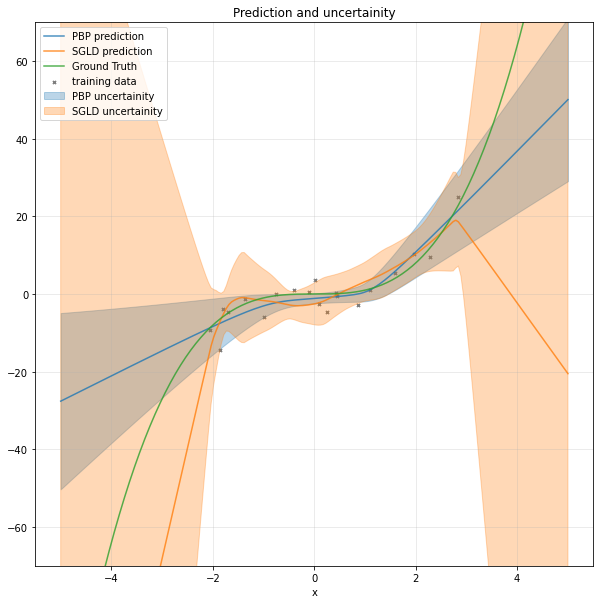

In [188]:
run_experiment(1, 50, x_train, y_train, x_test, x_plot, y_plot)